# Project Analysis using Thicket

In [2]:
import sys
# sys.path.append("/scratch/group/csce435-f23/python-3.8.17/lib/python3.8/site-packages")
# sys.path.append("/scratch/group/csce435-f23/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket.thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

<IPython.core.display.Javascript object>

### Read in all the files

In [37]:
tk_cuda_random = th.Thicket.from_caliperreader(glob("cuda_trial/random/*.cali"))
tk_cuda_2_20 = th.Thicket.from_caliperreader(glob("cuda_trial/2_20/*.cali"))
tk_mpi_random = th.Thicket.from_caliperreader(glob("mpi_trial/random/*.cali"))
tk_mpi_2_20 = th.Thicket.from_caliperreader(glob("mpi_trial/2_20/*.cali"))
tk_seq = th.Thicket.from_caliperreader(glob("seq_trial/*.cali"))

In [38]:
# Metadata
tk_cuda_random.metadata["num_threads"] = tk_cuda_random.metadata["InputSize"] // tk_cuda_random.metadata["num_blocks"]
tk_cuda_2_20.metadata["num_threads"] = tk_cuda_2_20.metadata["InputSize"] // tk_cuda_2_20.metadata["num_blocks"]
# tk_cuda_random.metadata
# tk_mpi_random.metadata
# tk_seq.metadata

In [11]:
# printing call trees
tk_cuda_random.statsframe.dataframe["time"] = 1
tk_mpi_random.statsframe.dataframe["time"] = 1
tk_seq.statsframe.dataframe["time"] = 1
# print(tk_cuda_random.tree())
# print(tk_mpi_random.tree())
# print(tk_seq.tree())

### Group and Clean Data

#### Sequential Data

In [95]:
# group and concat
gb_seq = tk_seq.groupby("InputSize")
ctk_seq = th.Thicket.concat_thickets(
    thickets=list(gb_seq.values()),
    headers=list(gb_seq.keys()),
    axis="columns",
    metadata_key="InputType"
)

# clean dataframe
ctk_seq.dataframe = ctk_seq.dataframe.reset_index().drop([("node", ""), (65536, "nid"), (65536, "spot.channel"), 
                                                  (65536, "Min time/rank"), (65536, "Max time/rank"), (65536, "Avg time/rank"), 
                                                  (1048576, "nid"), (1048576, "spot.channel"), (1048576, "Min time/rank"), 
                                                  (1048576, "Max time/rank"), (1048576, "Avg time/rank")], axis=1)
ctk_seq.dataframe = ctk_seq.dataframe.rename({("name", ""): "name", ("InputType", ""): "InputType"}).set_index(["name", "InputType"])
# ctk_seq.dataframe

2  thickets created...
{65536: <thicket.thicket.Thicket object at 0x000002871FBA2A70>, 1048576: <thicket.thicket.Thicket object at 0x000002871E715150>}


#### CUDA Data

In [97]:
# group and concat
gb_cuda_random = tk_cuda_random.groupby("InputSize")
ctk_cuda_random = th.Thicket.concat_thickets(
    thickets=list(gb_cuda_random.values()),
    headers=list(gb_cuda_random.keys()),
    axis="columns",
    metadata_key="num_threads"
)

# clean dataframe
ctk_cuda_random.dataframe = ctk_cuda_random.dataframe.reset_index().drop([("node", ""), (65536, "nid"), (65536, "spot.channel"), 
                                                  (65536, "Min time/rank"), (65536, "Max time/rank"), (65536, "Avg time/rank"), 
                                                  (65536, "Avg GPU time/rank"), (65536, "Min GPU time/rank"), (65536, "Max GPU time/rank"), 
                                                  (65536, "Total GPU time"), (1048576, "nid"), (1048576, "spot.channel"), 
                                                  (1048576, "Min time/rank"), (1048576, "Max time/rank"), (1048576, "Avg time/rank"), 
                                                  (1048576, "Avg GPU time/rank"), (1048576, "Min GPU time/rank"), (1048576, "Max GPU time/rank"), 
                                                  (1048576, "Total GPU time")], axis=1)
ctk_cuda_random.dataframe = ctk_cuda_random.dataframe.rename({("name", ""): "name", ("num_threads", ""): "num_threads"}).set_index(["name", "num_threads"])
# ctk_cuda_random.dataframe

# group and concat
gb_cuda_2_20 = tk_cuda_2_20.groupby("InputType")
ctk_cuda_2_20 = th.Thicket.concat_thickets(
    thickets=list(gb_cuda_2_20.values()),
    headers=list(gb_cuda_2_20.keys()),
    axis="columns",
    metadata_key="num_threads"
)

# clean dataframe
ctk_cuda_2_20.dataframe = ctk_cuda_2_20.dataframe.reset_index().drop([("node", ""), ("random", "nid"), ("random", "spot.channel"), 
                                                  ("random", "Min time/rank"), ("random", "Max time/rank"), ("random", "Avg time/rank"), 
                                                  ("random", "Avg GPU time/rank"), ("random", "Min GPU time/rank"), ("random", "Max GPU time/rank"), 
                                                  ("random", "Total GPU time"), ("nearly", "nid"), ("nearly", "spot.channel"), 
                                                  ("nearly", "Min time/rank"), ("nearly", "Max time/rank"), ("nearly", "Avg time/rank"), 
                                                  ("nearly", "Avg GPU time/rank"), ("nearly", "Min GPU time/rank"), ("nearly", "Max GPU time/rank"), 
                                                  ("nearly", "Total GPU time") , ("sorted", "nid"), ("sorted", "spot.channel"), 
                                                  ("sorted", "Min time/rank"), ("sorted", "Max time/rank"), ("sorted", "Avg time/rank"), 
                                                  ("sorted", "Avg GPU time/rank"), ("sorted", "Min GPU time/rank"), ("sorted", "Max GPU time/rank"), 
                                                  ("sorted", "Total GPU time") , ("reverse", "nid"), ("reverse", "spot.channel"), 
                                                  ("reverse", "Min time/rank"), ("reverse", "Max time/rank"), ("reverse", "Avg time/rank"), 
                                                  ("reverse", "Avg GPU time/rank"), ("reverse", "Min GPU time/rank"), ("reverse", "Max GPU time/rank"), 
                                                  ("reverse", "Total GPU time")], axis=1)
ctk_cuda_2_20.dataframe = ctk_cuda_2_20.dataframe.rename({("name", ""): "name", ("num_threads", ""): "num_threads"}).set_index(["name", "num_threads"])
# ctk_cuda_2_20.dataframe

2  thickets created...
{65536: <thicket.thicket.Thicket object at 0x0000028721C80A00>, 1048576: <thicket.thicket.Thicket object at 0x0000028719CBE3B0>}
4  thickets created...
{'nearly': <thicket.thicket.Thicket object at 0x000002871E86CF40>, 'random': <thicket.thicket.Thicket object at 0x000002871E86F280>, 'reverse': <thicket.thicket.Thicket object at 0x0000028721CA2D40>, 'sorted': <thicket.thicket.Thicket object at 0x0000028721CA00A0>}


#### MPI Data

In [45]:
# group and concat
gb_mpi_random = tk_mpi_random.groupby("InputSize")
ctk_mpi_random = th.Thicket.concat_thickets(
    thickets=list(gb_mpi_random.values()),
    headers=list(gb_mpi_random.keys()),
    axis="columns",
    metadata_key="num_procs"
)

# clean dataframe
ctk_mpi_random.dataframe = ctk_mpi_random.dataframe.reset_index().drop([("node", ""), (65536, "nid"), (65536, "spot.channel"), 
                                                  (65536, "Min time/rank"), (65536, "Max time/rank"), (65536, "Avg time/rank"), 
                                                  (65536, "Variance time/rank"), (1048576, "nid"), (1048576, "spot.channel"), 
                                                  (1048576, "Min time/rank"), (1048576, "Max time/rank"), (1048576, "Avg time/rank"), 
                                                  (1048576, "Variance time/rank")], axis=1)
ctk_mpi_random.dataframe = ctk_mpi_random.dataframe.rename({("name", ""): "name", ("num_procs", ""): "num_procs"}).set_index(["name", "num_procs"])
# ctk_mpi_random.dataframe

# group and concat
gb_mpi_2_20 = tk_mpi_2_20.groupby("InputType")
ctk_mpi_2_20 = th.Thicket.concat_thickets(
    thickets=list(gb_mpi_2_20.values()),
    headers=list(gb_mpi_2_20.keys()),
    axis="columns",
    metadata_key="num_procs"
)

# clean dataframe
ctk_mpi_2_20.dataframe = ctk_mpi_2_20.dataframe.reset_index().drop([("node", ""), ("random", "nid"), ("random", "spot.channel"), 
                                                  ("random", "Min time/rank"), ("random", "Max time/rank"), ("random", "Avg time/rank"), 
                                                  ("random", "Variance time/rank"), ("nearly", "nid"), ("nearly", "spot.channel"), 
                                                  ("nearly", "Min time/rank"), ("nearly", "Max time/rank"), ("nearly", "Avg time/rank"), 
                                                  ("nearly", "Variance time/rank"), ("sorted", "nid"), ("sorted", "spot.channel"), 
                                                  ("sorted", "Min time/rank"), ("sorted", "Max time/rank"), ("sorted", "Avg time/rank"), 
                                                  ("sorted", "Variance time/rank"), ("reverse", "nid"), ("reverse", "spot.channel"), 
                                                  ("reverse", "Min time/rank"), ("reverse", "Max time/rank"), ("reverse", "Avg time/rank"), 
                                                  ("reverse", "Variance time/rank")], axis=1)
ctk_mpi_2_20.dataframe = ctk_mpi_2_20.dataframe.rename({("name", ""): "name", ("num_procs", ""): "num_procs"}).set_index(["name", "num_procs"])
# ctk_mpi_2_20.dataframe

2  thickets created...
{65536: <thicket.thicket.Thicket object at 0x000002871E820A60>, 1048576: <thicket.thicket.Thicket object at 0x000002871E328FA0>}
4  thickets created...
{'nearly': <thicket.thicket.Thicket object at 0x000002871E1914B0>, 'random': <thicket.thicket.Thicket object at 0x000002871EA08A60>, 'reverse': <thicket.thicket.Thicket object at 0x000002871EA144F0>, 'sorted': <thicket.thicket.Thicket object at 0x000002871EA09CC0>}


### Plotting

#### Plot Functions

In [ ]:
# Define common variables
input_types = list(set(ctk_seq.dataframe.index.get_level_values("InputType")))
threads = sorted(list(set(ctk_cuda_random.dataframe.index.get_level_values("num_threads"))))
procs = sorted(list(set(ctk_mpi_random.dataframe.index.get_level_values("num_procs"))))
num_vals = [n[0] for n in ctk_cuda_random.dataframe.columns.tolist()]

In [94]:
def plot_strong(x, y, title, xlabel):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x, y, marker='o')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Speedup")
    plt.grid(True)
    plt.xscale("log", base=2)
    plt.show()
    return fig, ax

In [75]:
def plot_inputs(df, title, xlabel):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(
        df,
        marker='o',
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Total Time (seconds)")
    ax.legend(input_types)
    plt.grid(True)
    plt.xscale("log", base=2)
    plt.show()
    return fig, ax

In [92]:
def plot_comm_comp(x, comm, comp, title, xlabel):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x, comm, marker='o')
    ax.plot(x, comp, marker='o')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Percentage of Runtime (%)")
    ax.legend(["comm", "comp"])
    plt.grid(True)
    plt.xscale("log", base=2)
    plt.show()
    return fig, ax

#### Graphs

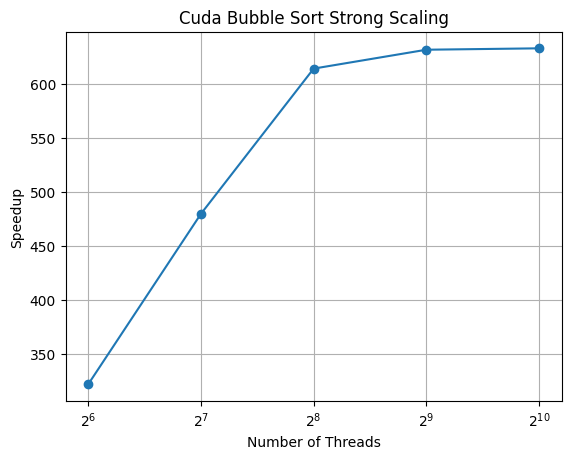

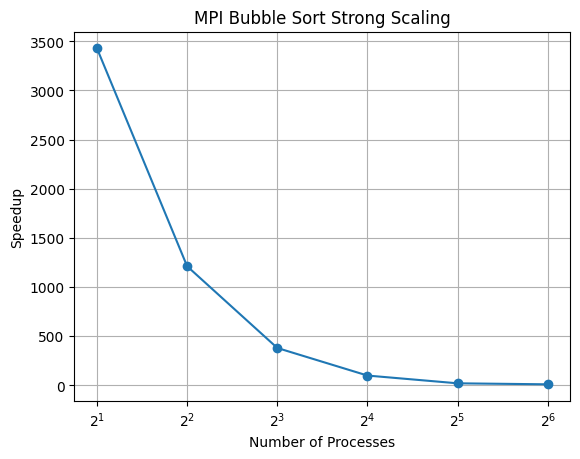

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MPI Bubble Sort Strong Scaling'}, xlabel='Number of Processes', ylabel='Speedup'>)

In [100]:
# strong scaling
t1 = ctk_seq.dataframe[1048576]["Total time"]["main"]["random"]
speedup_cuda = [t1/ctk_cuda_random.dataframe[1048576]["Total time"]["main"][t] for t in threads]
speedup_mpi = [t1/ctk_mpi_random.dataframe[1048576]["Total time"]["main"][p] for p in procs]

plot_strong(threads, speedup_cuda, "Cuda Bubble Sort Strong Scaling", "Number of Threads")
plot_strong(procs, speedup_mpi, "MPI Bubble Sort Strong Scaling", "Number of Processes")

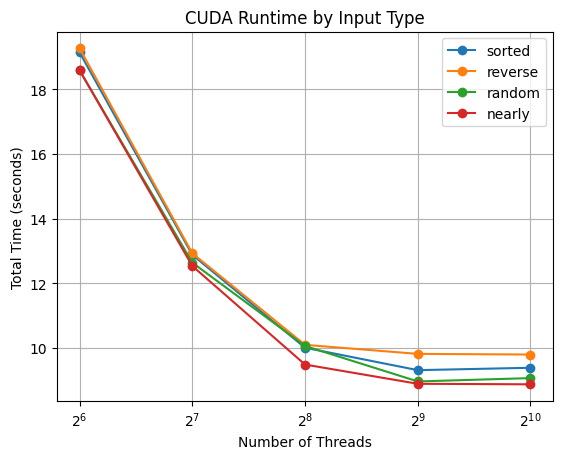

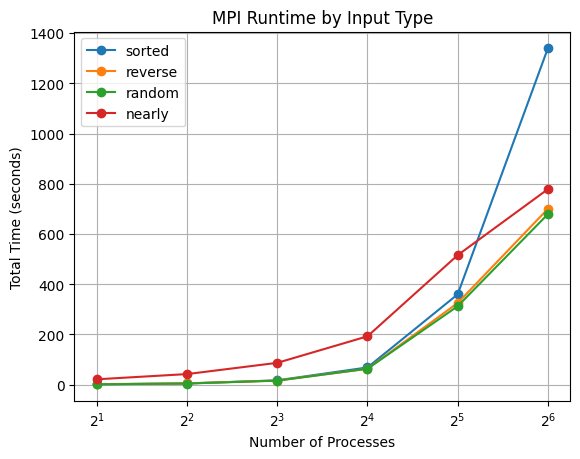

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MPI Runtime by Input Type'}, xlabel='Number of Processes', ylabel='Total Time (seconds)'>)

In [76]:
# comparing by input types
plot_inputs(ctk_cuda_2_20.dataframe.loc["main"], "CUDA Runtime by Input Type", "Number of Threads")
plot_inputs(ctk_mpi_2_20.dataframe.loc["main"], "MPI Runtime by Input Type", "Number of Processes")

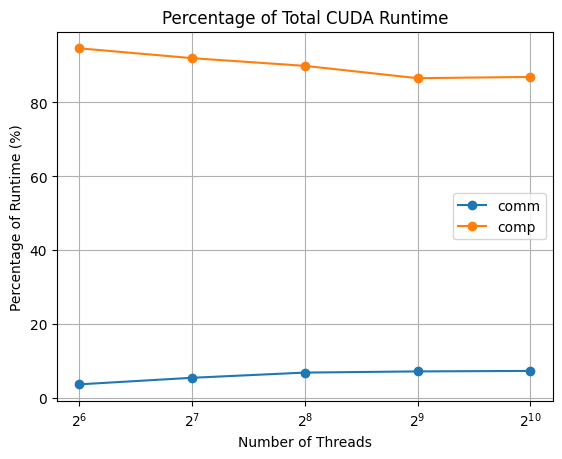

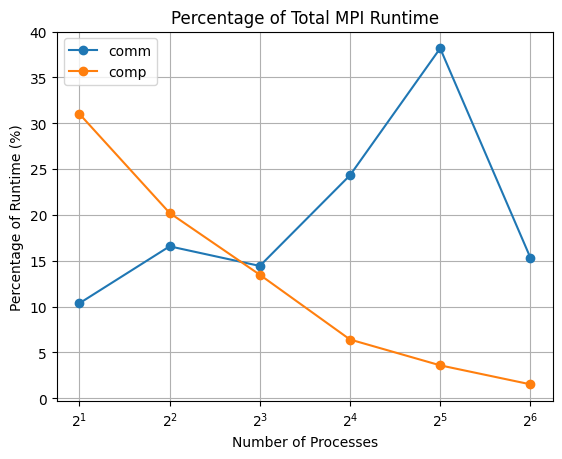

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Percentage of Total MPI Runtime'}, xlabel='Number of Processes', ylabel='Percentage of Runtime (%)'>)

In [99]:
# comparing comm and comp times
comm_per_cuda = [ctk_cuda_random.dataframe[1048576]["Total time"]["comm"][t] / ctk_cuda_random.dataframe[1048576]["Total time"]["main"][t] * 100 for t in threads]
comp_per_cuda = [ctk_cuda_random.dataframe[1048576]["Total time"]["comp"][t] / ctk_cuda_random.dataframe[1048576]["Total time"]["main"][t] * 100 for t in threads]
comm_per_mpi = [ctk_mpi_random.dataframe[1048576]["Total time"]["comm"][p] / ctk_mpi_random.dataframe[1048576]["Total time"]["main"][p] * 100 for p in procs]
comp_per_mpi = [ctk_mpi_random.dataframe[1048576]["Total time"]["comp"][p] / ctk_mpi_random.dataframe[1048576]["Total time"]["main"][p] * 100 for p in procs]

plot_comm_comp(threads, comm_per_cuda, comp_per_cuda, "Percentage of Total CUDA Runtime", "Number of Threads")
plot_comm_comp(procs, comm_per_mpi, comp_per_mpi, "Percentage of Total MPI Runtime", "Number of Processes")